# Metal Coordinating Network Oscillation

Fit oscillatory sweep of metal-coordinating polymer network.

**Data:** examples/data/oscillation/metal_networks/epstein.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rheojax.models import FractionalMaxwellModel
from rheojax.models import GeneralizedMaxwell
from rheojax.models import HerschelBulkley

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


## Load frequency sweep

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'oscillation' / 'metal_networks'
df = pd.read_csv(DATA_DIR / 'epstein.csv', sep='	')
df.columns = df.columns.str.strip()
omega = df.iloc[:,0].to_numpy()
Gp = df.iloc[:,1].to_numpy()
Gpp = df.iloc[:,2].to_numpy()
G_star = Gp + 1j*Gpp


## Fit models

In [4]:
gm = GeneralizedMaxwell(n_modes=4, modulus_type='tensile')
gm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega)
gm_pred = gm_pred_components[:,0] + 1j*gm_pred_components[:,1]
gm_r2 = r2_complex(G_star, gm_pred)

fm_pred = np.full_like(G_star, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega, test_mode='oscillation')
    fm_r2 = r2_complex(G_star, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.207500s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=3698.3106 | elapsed=3.207s | final_gradient_norm=6.3845e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.766005s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=3698.3106 | elapsed=0.766s | final_gradient_norm=6.3845e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.322948s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=1.1515e+04 | elapsed=1.323s | final_gradient_norm=4.9188e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.005948s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=52 | final_cost=0.0512 | elapsed=3.006s | final_gradient_norm=1.4156e-06


{'gm_r2': 0.9996876727417076, 'fm_r2': 0.9972276067149991}


## Plot fits

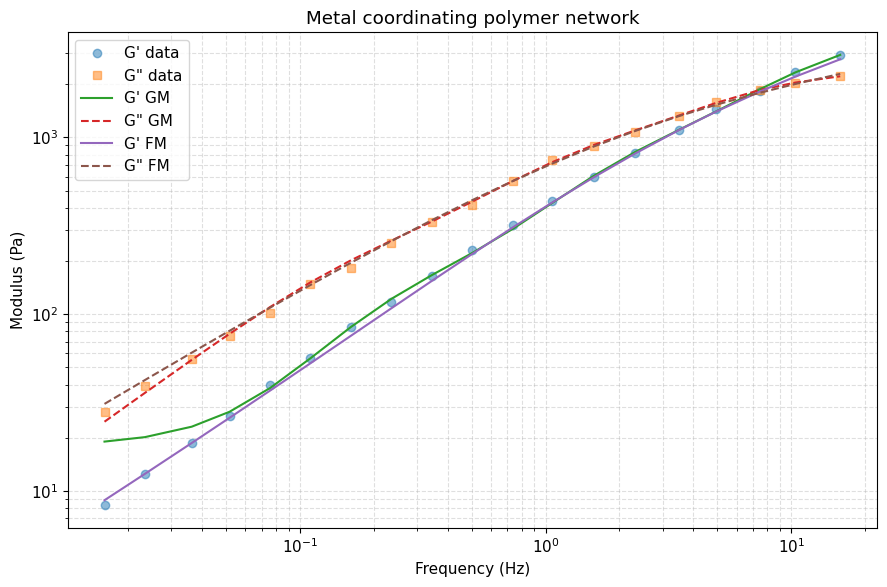

In [5]:
freq_hz = omega/(2*np.pi)
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(freq_hz, np.real(G_star), 'o', label="G' data", alpha=0.5)
ax.loglog(freq_hz, np.imag(G_star), 's', label='G" data', alpha=0.5)
ax.loglog(freq_hz, np.real(gm_pred), '-', label="G' GM")
ax.loglog(freq_hz, np.imag(gm_pred), '--', label='G" GM')
if np.isfinite(fm_r2):
    ax.loglog(freq_hz, np.real(fm_pred), '-', label="G' FM")
    ax.loglog(freq_hz, np.imag(fm_pred), '--', label='G" FM')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Modulus (Pa)')
ax.set_title('Metal coordinating polymer network')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.842509s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=3698.3106 | elapsed=0.843s | final_gradient_norm=6.3845e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.924600s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=3698.3106 | elapsed=0.925s | final_gradient_norm=6.3845e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.556848s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=1.1515e+04 | elapsed=0.557s | final_gradient_norm=4.9188e+08


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
TypeError: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Skipping gm due to predict error: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.948922s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=52 | final_cost=0.0512 | elapsed=0.949s | final_gradient_norm=1.4156e-06


Model ranking (R²): [('fm', 0.997)]


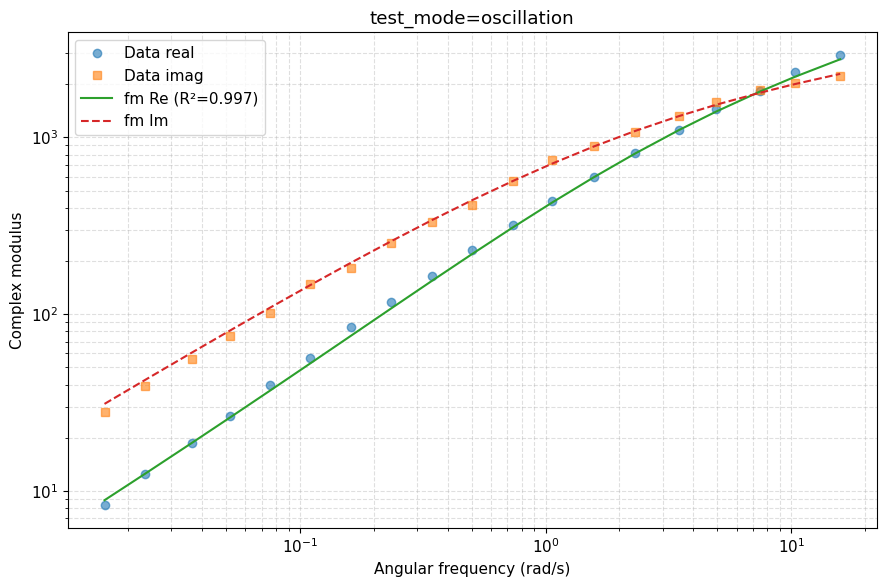

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:03<4:04:56,  3.67s/it]

warmup:   0%|          | 2/4000 [00:08<4:53:20,  4.40s/it]

warmup:   0%|          | 8/4000 [00:08<49:47,  1.34it/s]  

warmup:   0%|          | 10/4000 [00:08<37:04,  1.79it/s]

warmup:   0%|          | 12/4000 [00:09<27:48,  2.39it/s]

warmup:   0%|          | 15/4000 [00:09<18:24,  3.61it/s]

warmup:   0%|          | 20/4000 [00:09<10:17,  6.44it/s]

warmup:   1%|          | 24/4000 [00:09<07:22,  8.98it/s]

warmup:   1%|          | 28/4000 [00:09<05:28, 12.11it/s]

warmup:   1%|          | 33/4000 [00:09<03:55, 16.87it/s]

warmup:   1%|          | 38/4000 [00:09<03:13, 20.48it/s]

warmup:   1%|          | 43/4000 [00:09<02:42, 24.33it/s]

warmup:   1%|          | 47/4000 [00:10<02:44, 24.10it/s]

warmup:   1%|▏         | 52/4000 [00:10<02:18, 28.47it/s]

warmup:   1%|▏         | 57/4000 [00:10<02:03, 31.92it/s]

warmup:   2%|▏         | 61/4000 [00:10<02:03, 31.91it/s]

warmup:   2%|▏         | 65/4000 [00:10<02:09, 30.41it/s]

warmup:   2%|▏         | 69/4000 [00:10<02:03, 31.77it/s]

warmup:   2%|▏         | 74/4000 [00:10<02:00, 32.65it/s]

warmup:   2%|▏         | 78/4000 [00:10<02:09, 30.31it/s]

warmup:   2%|▏         | 83/4000 [00:11<01:54, 34.20it/s]

warmup:   2%|▏         | 88/4000 [00:11<01:46, 36.85it/s]

warmup:   2%|▏         | 92/4000 [00:11<01:47, 36.21it/s]

warmup:   2%|▏         | 98/4000 [00:11<01:34, 41.25it/s]

warmup:   3%|▎         | 103/4000 [00:11<01:33, 41.80it/s]

warmup:   3%|▎         | 110/4000 [00:11<01:20, 48.07it/s]

warmup:   3%|▎         | 118/4000 [00:11<01:11, 54.55it/s]

warmup:   3%|▎         | 124/4000 [00:11<01:20, 48.26it/s]

warmup:   3%|▎         | 129/4000 [00:12<01:19, 48.47it/s]

warmup:   3%|▎         | 135/4000 [00:12<01:15, 51.25it/s]

warmup:   4%|▎         | 142/4000 [00:12<01:12, 53.22it/s]

warmup:   4%|▍         | 150/4000 [00:12<01:04, 59.96it/s]

warmup:   4%|▍         | 157/4000 [00:12<01:07, 57.03it/s]

warmup:   4%|▍         | 163/4000 [00:12<01:13, 52.54it/s]

warmup:   4%|▍         | 169/4000 [00:12<01:15, 50.53it/s]

warmup:   4%|▍         | 176/4000 [00:12<01:09, 55.26it/s]

warmup:   5%|▍         | 186/4000 [00:12<01:01, 62.26it/s]

warmup:   5%|▍         | 193/4000 [00:13<01:01, 62.10it/s]

warmup:   5%|▌         | 200/4000 [00:13<01:01, 61.85it/s]

warmup:   5%|▌         | 209/4000 [00:13<00:55, 68.75it/s]

warmup:   5%|▌         | 218/4000 [00:13<00:50, 74.46it/s]

warmup:   6%|▌         | 226/4000 [00:13<00:50, 74.78it/s]

warmup:   6%|▌         | 234/4000 [00:13<00:51, 72.86it/s]

warmup:   6%|▌         | 242/4000 [00:13<00:54, 68.62it/s]

warmup:   6%|▋         | 251/4000 [00:13<00:51, 72.56it/s]

warmup:   6%|▋         | 259/4000 [00:14<01:00, 61.89it/s]

warmup:   7%|▋         | 266/4000 [00:14<01:07, 55.40it/s]

warmup:   7%|▋         | 272/4000 [00:14<01:12, 51.68it/s]

warmup:   7%|▋         | 280/4000 [00:14<01:07, 55.45it/s]

warmup:   7%|▋         | 289/4000 [00:14<00:58, 63.09it/s]

warmup:   7%|▋         | 296/4000 [00:14<00:57, 64.60it/s]

warmup:   8%|▊         | 306/4000 [00:14<00:50, 73.43it/s]

warmup:   8%|▊         | 315/4000 [00:14<00:47, 77.42it/s]

warmup:   8%|▊         | 323/4000 [00:15<00:49, 73.58it/s]

warmup:   8%|▊         | 331/4000 [00:15<00:58, 62.82it/s]

warmup:   8%|▊         | 338/4000 [00:15<01:00, 60.80it/s]

warmup:   9%|▊         | 347/4000 [00:15<00:54, 67.58it/s]

warmup:   9%|▉         | 357/4000 [00:15<00:48, 74.39it/s]

warmup:   9%|▉         | 367/4000 [00:15<00:47, 77.12it/s]

warmup:   9%|▉         | 375/4000 [00:15<00:46, 77.29it/s]

warmup:  10%|▉         | 383/4000 [00:15<00:46, 76.97it/s]

warmup:  10%|▉         | 391/4000 [00:15<00:50, 71.56it/s]

warmup:  10%|▉         | 399/4000 [00:16<00:49, 73.36it/s]

warmup:  10%|█         | 407/4000 [00:16<01:01, 58.71it/s]

warmup:  10%|█         | 414/4000 [00:16<01:03, 56.63it/s]

warmup:  11%|█         | 421/4000 [00:16<01:00, 59.18it/s]

warmup:  11%|█         | 429/4000 [00:16<00:55, 64.26it/s]

warmup:  11%|█         | 437/4000 [00:16<00:56, 62.82it/s]

warmup:  11%|█         | 444/4000 [00:16<01:01, 57.84it/s]

warmup:  11%|█▏        | 450/4000 [00:17<01:00, 58.22it/s]

warmup:  11%|█▏        | 456/4000 [00:17<01:05, 53.98it/s]

warmup:  12%|█▏        | 462/4000 [00:17<01:13, 48.12it/s]

warmup:  12%|█▏        | 467/4000 [00:17<01:21, 43.48it/s]

warmup:  12%|█▏        | 472/4000 [00:17<01:18, 44.68it/s]

warmup:  12%|█▏        | 477/4000 [00:17<01:18, 44.92it/s]

warmup:  12%|█▏        | 482/4000 [00:17<01:16, 46.05it/s]

warmup:  12%|█▏        | 490/4000 [00:17<01:04, 54.30it/s]

warmup:  12%|█▏        | 498/4000 [00:17<00:58, 59.92it/s]

warmup:  13%|█▎        | 506/4000 [00:18<00:54, 64.27it/s]

warmup:  13%|█▎        | 513/4000 [00:18<00:53, 65.43it/s]

warmup:  13%|█▎        | 520/4000 [00:18<00:53, 64.60it/s]

warmup:  13%|█▎        | 527/4000 [00:18<00:53, 65.34it/s]

warmup:  13%|█▎        | 536/4000 [00:18<00:48, 72.09it/s]

warmup:  14%|█▎        | 544/4000 [00:18<00:49, 70.02it/s]

warmup:  14%|█▍        | 552/4000 [00:18<00:51, 66.89it/s]

warmup:  14%|█▍        | 559/4000 [00:18<00:51, 66.41it/s]

warmup:  14%|█▍        | 567/4000 [00:18<00:48, 70.12it/s]

warmup:  14%|█▍        | 576/4000 [00:19<00:45, 75.05it/s]

warmup:  15%|█▍        | 584/4000 [00:19<00:49, 68.90it/s]

warmup:  15%|█▍        | 592/4000 [00:19<00:53, 64.02it/s]

warmup:  15%|█▍        | 599/4000 [00:19<00:55, 61.31it/s]

warmup:  15%|█▌        | 606/4000 [00:19<00:56, 59.59it/s]

warmup:  15%|█▌        | 613/4000 [00:19<00:55, 60.58it/s]

warmup:  16%|█▌        | 620/4000 [00:19<00:56, 60.32it/s]

warmup:  16%|█▌        | 627/4000 [00:19<00:58, 57.74it/s]

warmup:  16%|█▌        | 634/4000 [00:20<00:57, 58.49it/s]

warmup:  16%|█▌        | 640/4000 [00:20<01:06, 50.80it/s]

warmup:  16%|█▌        | 646/4000 [00:20<01:04, 52.07it/s]

warmup:  16%|█▋        | 654/4000 [00:20<00:58, 56.80it/s]

warmup:  16%|█▋        | 660/4000 [00:20<00:58, 56.76it/s]

warmup:  17%|█▋        | 666/4000 [00:20<01:04, 51.50it/s]

warmup:  17%|█▋        | 672/4000 [00:20<01:05, 50.84it/s]

warmup:  17%|█▋        | 678/4000 [00:20<01:03, 52.51it/s]

warmup:  17%|█▋        | 684/4000 [00:21<01:05, 50.80it/s]

warmup:  17%|█▋        | 690/4000 [00:21<01:05, 50.21it/s]

warmup:  17%|█▋        | 699/4000 [00:21<00:55, 59.50it/s]

warmup:  18%|█▊        | 706/4000 [00:21<00:55, 59.86it/s]

warmup:  18%|█▊        | 713/4000 [00:21<00:56, 57.76it/s]

warmup:  18%|█▊        | 719/4000 [00:21<01:00, 54.42it/s]

warmup:  18%|█▊        | 728/4000 [00:21<00:51, 63.03it/s]

warmup:  18%|█▊        | 737/4000 [00:21<00:47, 68.19it/s]

warmup:  19%|█▊        | 745/4000 [00:22<00:48, 67.80it/s]

warmup:  19%|█▉        | 752/4000 [00:22<00:54, 60.00it/s]

warmup:  19%|█▉        | 759/4000 [00:22<00:56, 57.23it/s]

warmup:  19%|█▉        | 765/4000 [00:22<00:56, 56.76it/s]

warmup:  19%|█▉        | 771/4000 [00:22<00:56, 57.18it/s]

warmup:  19%|█▉        | 778/4000 [00:22<00:54, 59.12it/s]

warmup:  20%|█▉        | 787/4000 [00:22<00:48, 66.81it/s]

warmup:  20%|█▉        | 794/4000 [00:22<00:50, 63.82it/s]

warmup:  20%|██        | 801/4000 [00:22<00:50, 63.85it/s]

warmup:  20%|██        | 812/4000 [00:23<00:42, 75.42it/s]

warmup:  20%|██        | 820/4000 [00:23<00:49, 64.28it/s]

warmup:  21%|██        | 829/4000 [00:23<00:45, 70.31it/s]

warmup:  21%|██        | 837/4000 [00:23<00:47, 66.05it/s]

warmup:  21%|██        | 844/4000 [00:23<00:47, 66.75it/s]

warmup:  21%|██▏       | 851/4000 [00:23<00:49, 63.85it/s]

warmup:  21%|██▏       | 858/4000 [00:23<00:50, 62.32it/s]

warmup:  22%|██▏       | 868/4000 [00:23<00:45, 68.62it/s]

warmup:  22%|██▏       | 875/4000 [00:24<00:46, 66.80it/s]

warmup:  22%|██▏       | 882/4000 [00:24<00:46, 67.37it/s]

warmup:  22%|██▏       | 889/4000 [00:24<00:55, 55.91it/s]

warmup:  22%|██▏       | 897/4000 [00:24<00:51, 60.51it/s]

warmup:  23%|██▎       | 904/4000 [00:24<00:50, 61.80it/s]

warmup:  23%|██▎       | 912/4000 [00:24<00:47, 64.74it/s]

warmup:  23%|██▎       | 919/4000 [00:24<00:47, 65.00it/s]

warmup:  23%|██▎       | 926/4000 [00:24<00:50, 60.43it/s]

warmup:  23%|██▎       | 933/4000 [00:25<00:55, 55.00it/s]

warmup:  24%|██▎       | 941/4000 [00:25<00:50, 61.00it/s]

warmup:  24%|██▎       | 948/4000 [00:25<00:52, 58.00it/s]

warmup:  24%|██▍       | 954/4000 [00:25<00:55, 55.06it/s]

warmup:  24%|██▍       | 960/4000 [00:25<01:02, 48.55it/s]

warmup:  24%|██▍       | 966/4000 [00:25<01:15, 40.03it/s]

warmup:  24%|██▍       | 971/4000 [00:25<01:18, 38.80it/s]

warmup:  24%|██▍       | 976/4000 [00:26<01:15, 40.08it/s]

warmup:  25%|██▍       | 982/4000 [00:26<01:08, 44.05it/s]

warmup:  25%|██▍       | 987/4000 [00:26<01:08, 43.80it/s]

warmup:  25%|██▍       | 997/4000 [00:26<00:53, 56.64it/s]

sample:  25%|██▌       | 1004/4000 [00:26<00:54, 54.74it/s]

sample:  25%|██▌       | 1012/4000 [00:26<00:51, 58.34it/s]

sample:  25%|██▌       | 1018/4000 [00:26<00:52, 56.60it/s]

sample:  26%|██▌       | 1024/4000 [00:26<00:57, 52.05it/s]

sample:  26%|██▌       | 1032/4000 [00:27<00:54, 54.94it/s]

sample:  26%|██▌       | 1041/4000 [00:27<00:46, 63.38it/s]

sample:  26%|██▌       | 1048/4000 [00:27<00:47, 62.28it/s]

sample:  26%|██▋       | 1055/4000 [00:27<00:51, 57.03it/s]

sample:  27%|██▋       | 1064/4000 [00:27<00:46, 63.50it/s]

sample:  27%|██▋       | 1073/4000 [00:27<00:45, 65.03it/s]

sample:  27%|██▋       | 1081/4000 [00:27<00:42, 68.18it/s]

sample:  27%|██▋       | 1088/4000 [00:27<00:44, 65.51it/s]

sample:  27%|██▋       | 1095/4000 [00:27<00:47, 61.01it/s]

sample:  28%|██▊       | 1102/4000 [00:28<00:48, 59.96it/s]

sample:  28%|██▊       | 1110/4000 [00:28<00:48, 59.47it/s]

sample:  28%|██▊       | 1117/4000 [00:28<00:47, 60.52it/s]

sample:  28%|██▊       | 1124/4000 [00:28<00:50, 57.05it/s]

sample:  28%|██▊       | 1130/4000 [00:28<00:50, 57.39it/s]

sample:  28%|██▊       | 1136/4000 [00:28<00:50, 56.23it/s]

sample:  29%|██▊       | 1142/4000 [00:28<00:50, 56.18it/s]

sample:  29%|██▊       | 1148/4000 [00:28<00:53, 53.14it/s]

sample:  29%|██▉       | 1154/4000 [00:29<00:52, 54.70it/s]

sample:  29%|██▉       | 1163/4000 [00:29<00:45, 62.68it/s]

sample:  29%|██▉       | 1170/4000 [00:29<00:44, 62.90it/s]

sample:  29%|██▉       | 1177/4000 [00:29<00:47, 59.34it/s]

sample:  30%|██▉       | 1186/4000 [00:29<00:42, 66.45it/s]

sample:  30%|██▉       | 1193/4000 [00:29<00:45, 61.25it/s]

sample:  30%|███       | 1200/4000 [00:29<00:50, 55.58it/s]

sample:  30%|███       | 1207/4000 [00:29<00:50, 55.47it/s]

sample:  30%|███       | 1213/4000 [00:30<00:51, 54.53it/s]

sample:  30%|███       | 1219/4000 [00:30<00:51, 54.05it/s]

sample:  31%|███       | 1226/4000 [00:30<00:47, 57.97it/s]

sample:  31%|███       | 1232/4000 [00:30<00:48, 56.65it/s]

sample:  31%|███       | 1239/4000 [00:30<00:46, 59.57it/s]

sample:  31%|███       | 1246/4000 [00:30<00:46, 58.81it/s]

sample:  31%|███▏      | 1252/4000 [00:30<00:47, 58.08it/s]

sample:  31%|███▏      | 1258/4000 [00:30<00:47, 57.41it/s]

sample:  32%|███▏      | 1264/4000 [00:30<00:50, 54.13it/s]

sample:  32%|███▏      | 1270/4000 [00:31<01:03, 42.99it/s]

sample:  32%|███▏      | 1275/4000 [00:31<01:02, 43.41it/s]

sample:  32%|███▏      | 1282/4000 [00:31<00:57, 47.36it/s]

sample:  32%|███▏      | 1288/4000 [00:31<00:54, 50.05it/s]

sample:  32%|███▏      | 1296/4000 [00:31<00:46, 57.68it/s]

sample:  33%|███▎      | 1303/4000 [00:31<00:47, 57.26it/s]

sample:  33%|███▎      | 1312/4000 [00:31<00:41, 65.47it/s]

sample:  33%|███▎      | 1320/4000 [00:31<00:40, 66.47it/s]

sample:  33%|███▎      | 1327/4000 [00:32<00:42, 62.32it/s]

sample:  33%|███▎      | 1334/4000 [00:32<00:43, 60.76it/s]

sample:  34%|███▎      | 1341/4000 [00:32<00:45, 58.18it/s]

sample:  34%|███▎      | 1348/4000 [00:32<00:44, 59.91it/s]

sample:  34%|███▍      | 1356/4000 [00:32<00:41, 64.02it/s]

sample:  34%|███▍      | 1363/4000 [00:32<00:42, 61.51it/s]

sample:  34%|███▍      | 1370/4000 [00:32<00:45, 57.72it/s]

sample:  34%|███▍      | 1376/4000 [00:32<00:48, 54.28it/s]

sample:  35%|███▍      | 1383/4000 [00:33<00:45, 58.02it/s]

sample:  35%|███▍      | 1389/4000 [00:33<00:45, 56.83it/s]

sample:  35%|███▍      | 1396/4000 [00:33<00:44, 58.42it/s]

sample:  35%|███▌      | 1402/4000 [00:33<00:52, 49.89it/s]

sample:  35%|███▌      | 1412/4000 [00:33<00:41, 61.92it/s]

sample:  35%|███▌      | 1419/4000 [00:33<00:42, 61.31it/s]

sample:  36%|███▌      | 1426/4000 [00:33<00:44, 58.44it/s]

sample:  36%|███▌      | 1433/4000 [00:33<00:47, 53.98it/s]

sample:  36%|███▌      | 1439/4000 [00:34<00:49, 51.34it/s]

sample:  36%|███▌      | 1446/4000 [00:34<00:46, 55.10it/s]

sample:  36%|███▋      | 1452/4000 [00:34<00:47, 53.43it/s]

sample:  36%|███▋      | 1460/4000 [00:34<00:43, 57.79it/s]

sample:  37%|███▋      | 1466/4000 [00:34<00:44, 56.78it/s]

sample:  37%|███▋      | 1472/4000 [00:34<00:45, 55.78it/s]

sample:  37%|███▋      | 1479/4000 [00:34<00:42, 58.89it/s]

sample:  37%|███▋      | 1485/4000 [00:34<00:43, 57.31it/s]

sample:  37%|███▋      | 1492/4000 [00:34<00:41, 59.96it/s]

sample:  37%|███▋      | 1499/4000 [00:35<00:44, 55.60it/s]

sample:  38%|███▊      | 1505/4000 [00:35<00:45, 55.08it/s]

sample:  38%|███▊      | 1511/4000 [00:35<00:45, 55.13it/s]

sample:  38%|███▊      | 1520/4000 [00:35<00:40, 61.60it/s]

sample:  38%|███▊      | 1527/4000 [00:35<00:39, 63.17it/s]

sample:  38%|███▊      | 1534/4000 [00:35<00:39, 62.72it/s]

sample:  39%|███▊      | 1544/4000 [00:35<00:34, 70.41it/s]

sample:  39%|███▉      | 1552/4000 [00:35<00:38, 63.78it/s]

sample:  39%|███▉      | 1559/4000 [00:36<00:37, 65.05it/s]

sample:  39%|███▉      | 1567/4000 [00:36<00:35, 68.61it/s]

sample:  39%|███▉      | 1575/4000 [00:36<00:34, 69.39it/s]

sample:  40%|███▉      | 1584/4000 [00:36<00:32, 74.38it/s]

sample:  40%|███▉      | 1592/4000 [00:36<00:33, 71.30it/s]

sample:  40%|████      | 1600/4000 [00:36<00:38, 62.63it/s]

sample:  40%|████      | 1607/4000 [00:36<00:39, 59.91it/s]

sample:  40%|████      | 1614/4000 [00:36<00:41, 57.73it/s]

sample:  40%|████      | 1620/4000 [00:37<00:43, 54.29it/s]

sample:  41%|████      | 1626/4000 [00:37<00:45, 52.34it/s]

sample:  41%|████      | 1632/4000 [00:37<00:44, 53.31it/s]

sample:  41%|████      | 1638/4000 [00:37<00:43, 54.44it/s]

sample:  41%|████      | 1645/4000 [00:37<00:41, 56.96it/s]

sample:  41%|████▏     | 1651/4000 [00:37<00:43, 54.41it/s]

sample:  41%|████▏     | 1658/4000 [00:37<00:40, 57.38it/s]

sample:  42%|████▏     | 1664/4000 [00:37<00:44, 52.40it/s]

sample:  42%|████▏     | 1670/4000 [00:37<00:44, 52.84it/s]

sample:  42%|████▏     | 1679/4000 [00:38<00:37, 61.30it/s]

sample:  42%|████▏     | 1687/4000 [00:38<00:35, 64.85it/s]

sample:  42%|████▏     | 1694/4000 [00:38<00:35, 65.46it/s]

sample:  43%|████▎     | 1702/4000 [00:38<00:33, 67.61it/s]

sample:  43%|████▎     | 1709/4000 [00:38<00:37, 60.89it/s]

sample:  43%|████▎     | 1716/4000 [00:38<00:40, 56.47it/s]

sample:  43%|████▎     | 1722/4000 [00:38<00:45, 50.22it/s]

sample:  43%|████▎     | 1728/4000 [00:38<00:44, 51.63it/s]

sample:  43%|████▎     | 1734/4000 [00:39<00:49, 46.24it/s]

sample:  44%|████▎     | 1740/4000 [00:39<00:47, 47.96it/s]

sample:  44%|████▎     | 1745/4000 [00:39<00:55, 40.92it/s]

sample:  44%|████▍     | 1750/4000 [00:39<01:06, 33.90it/s]

sample:  44%|████▍     | 1756/4000 [00:39<00:59, 37.75it/s]

sample:  44%|████▍     | 1761/4000 [00:39<00:57, 38.67it/s]

sample:  44%|████▍     | 1767/4000 [00:39<00:54, 41.21it/s]

sample:  44%|████▍     | 1774/4000 [00:40<00:47, 47.05it/s]

sample:  44%|████▍     | 1780/4000 [00:40<00:47, 47.16it/s]

sample:  45%|████▍     | 1788/4000 [00:40<00:40, 54.32it/s]

sample:  45%|████▍     | 1796/4000 [00:40<00:37, 58.84it/s]

sample:  45%|████▌     | 1803/4000 [00:40<00:40, 54.45it/s]

sample:  45%|████▌     | 1809/4000 [00:40<00:42, 51.87it/s]

sample:  45%|████▌     | 1815/4000 [00:40<00:42, 51.29it/s]

sample:  46%|████▌     | 1824/4000 [00:40<00:36, 58.96it/s]

sample:  46%|████▌     | 1832/4000 [00:41<00:33, 63.85it/s]

sample:  46%|████▌     | 1839/4000 [00:41<00:38, 55.54it/s]

sample:  46%|████▌     | 1845/4000 [00:41<00:38, 56.10it/s]

sample:  46%|████▋     | 1851/4000 [00:41<00:39, 54.81it/s]

sample:  46%|████▋     | 1859/4000 [00:41<00:34, 61.36it/s]

sample:  47%|████▋     | 1866/4000 [00:41<00:36, 58.22it/s]

sample:  47%|████▋     | 1872/4000 [00:41<00:37, 56.11it/s]

sample:  47%|████▋     | 1878/4000 [00:41<00:38, 55.19it/s]

sample:  47%|████▋     | 1885/4000 [00:42<00:38, 55.44it/s]

sample:  47%|████▋     | 1891/4000 [00:42<00:37, 56.51it/s]

sample:  47%|████▋     | 1897/4000 [00:42<00:40, 51.94it/s]

sample:  48%|████▊     | 1906/4000 [00:42<00:34, 60.09it/s]

sample:  48%|████▊     | 1914/4000 [00:42<00:33, 62.11it/s]

sample:  48%|████▊     | 1921/4000 [00:42<00:34, 60.72it/s]

sample:  48%|████▊     | 1928/4000 [00:42<00:34, 60.30it/s]

sample:  48%|████▊     | 1936/4000 [00:42<00:32, 64.04it/s]

sample:  49%|████▊     | 1943/4000 [00:42<00:33, 61.87it/s]

sample:  49%|████▉     | 1950/4000 [00:43<00:35, 57.30it/s]

sample:  49%|████▉     | 1958/4000 [00:43<00:33, 60.33it/s]

sample:  49%|████▉     | 1965/4000 [00:43<00:36, 56.42it/s]

sample:  49%|████▉     | 1971/4000 [00:43<00:37, 54.70it/s]

sample:  49%|████▉     | 1978/4000 [00:43<00:34, 58.29it/s]

sample:  50%|████▉     | 1985/4000 [00:43<00:33, 60.67it/s]

sample:  50%|████▉     | 1993/4000 [00:43<00:31, 63.37it/s]

sample:  50%|█████     | 2002/4000 [00:43<00:29, 68.11it/s]

sample:  50%|█████     | 2009/4000 [00:44<00:29, 66.91it/s]

sample:  50%|█████     | 2016/4000 [00:44<00:34, 58.29it/s]

sample:  51%|█████     | 2023/4000 [00:44<00:34, 56.62it/s]

sample:  51%|█████     | 2029/4000 [00:44<00:37, 53.12it/s]

sample:  51%|█████     | 2035/4000 [00:44<00:36, 53.38it/s]

sample:  51%|█████     | 2041/4000 [00:44<00:37, 51.87it/s]

sample:  51%|█████     | 2047/4000 [00:44<00:39, 48.93it/s]

sample:  51%|█████▏    | 2052/4000 [00:44<00:41, 47.48it/s]

sample:  51%|█████▏    | 2058/4000 [00:45<00:40, 48.20it/s]

sample:  52%|█████▏    | 2066/4000 [00:45<00:35, 54.82it/s]

sample:  52%|█████▏    | 2072/4000 [00:45<00:34, 56.01it/s]

sample:  52%|█████▏    | 2078/4000 [00:45<00:34, 56.23it/s]

sample:  52%|█████▏    | 2084/4000 [00:45<00:37, 51.42it/s]

sample:  52%|█████▏    | 2090/4000 [00:45<00:36, 52.32it/s]

sample:  52%|█████▏    | 2096/4000 [00:45<00:37, 50.24it/s]

sample:  53%|█████▎    | 2103/4000 [00:45<00:36, 52.26it/s]

sample:  53%|█████▎    | 2109/4000 [00:46<00:37, 50.20it/s]

sample:  53%|█████▎    | 2115/4000 [00:46<00:38, 49.34it/s]

sample:  53%|█████▎    | 2120/4000 [00:46<00:40, 46.12it/s]

sample:  53%|█████▎    | 2125/4000 [00:46<00:42, 44.01it/s]

sample:  53%|█████▎    | 2131/4000 [00:46<00:38, 48.03it/s]

sample:  53%|█████▎    | 2139/4000 [00:46<00:33, 55.15it/s]

sample:  54%|█████▎    | 2146/4000 [00:46<00:32, 57.64it/s]

sample:  54%|█████▍    | 2154/4000 [00:46<00:30, 60.70it/s]

sample:  54%|█████▍    | 2161/4000 [00:46<00:30, 61.21it/s]

sample:  54%|█████▍    | 2168/4000 [00:47<00:29, 62.60it/s]

sample:  54%|█████▍    | 2175/4000 [00:47<00:30, 60.00it/s]

sample:  55%|█████▍    | 2183/4000 [00:47<00:28, 63.99it/s]

sample:  55%|█████▍    | 2191/4000 [00:47<00:28, 62.86it/s]

sample:  55%|█████▍    | 2198/4000 [00:47<00:29, 62.07it/s]

sample:  55%|█████▌    | 2206/4000 [00:47<00:27, 64.31it/s]

sample:  55%|█████▌    | 2213/4000 [00:47<00:27, 64.62it/s]

sample:  56%|█████▌    | 2220/4000 [00:47<00:28, 63.11it/s]

sample:  56%|█████▌    | 2227/4000 [00:48<00:28, 61.44it/s]

sample:  56%|█████▌    | 2236/4000 [00:48<00:25, 68.74it/s]

sample:  56%|█████▌    | 2243/4000 [00:48<00:27, 62.96it/s]

sample:  56%|█████▋    | 2250/4000 [00:48<00:29, 60.20it/s]

sample:  56%|█████▋    | 2257/4000 [00:48<00:28, 61.90it/s]

sample:  57%|█████▋    | 2264/4000 [00:48<00:28, 61.73it/s]

sample:  57%|█████▋    | 2271/4000 [00:48<00:30, 56.40it/s]

sample:  57%|█████▋    | 2278/4000 [00:48<00:29, 57.72it/s]

sample:  57%|█████▋    | 2284/4000 [00:48<00:30, 55.76it/s]

sample:  57%|█████▋    | 2292/4000 [00:49<00:27, 61.06it/s]

sample:  57%|█████▋    | 2299/4000 [00:49<00:29, 57.14it/s]

sample:  58%|█████▊    | 2305/4000 [00:49<00:30, 55.61it/s]

sample:  58%|█████▊    | 2311/4000 [00:49<00:31, 54.33it/s]

sample:  58%|█████▊    | 2317/4000 [00:49<00:32, 52.28it/s]

sample:  58%|█████▊    | 2324/4000 [00:49<00:29, 56.75it/s]

sample:  58%|█████▊    | 2335/4000 [00:49<00:24, 69.11it/s]

sample:  59%|█████▊    | 2343/4000 [00:49<00:29, 56.72it/s]

sample:  59%|█████▉    | 2350/4000 [00:50<00:31, 52.01it/s]

sample:  59%|█████▉    | 2356/4000 [00:50<00:30, 53.53it/s]

sample:  59%|█████▉    | 2363/4000 [00:50<00:28, 57.49it/s]

sample:  59%|█████▉    | 2370/4000 [00:50<00:28, 57.78it/s]

sample:  59%|█████▉    | 2376/4000 [00:50<00:28, 57.31it/s]

sample:  60%|█████▉    | 2383/4000 [00:50<00:27, 59.09it/s]

sample:  60%|█████▉    | 2392/4000 [00:50<00:24, 66.53it/s]

sample:  60%|██████    | 2400/4000 [00:50<00:23, 68.43it/s]

sample:  60%|██████    | 2408/4000 [00:51<00:22, 70.42it/s]

sample:  60%|██████    | 2416/4000 [00:51<00:25, 63.24it/s]

sample:  61%|██████    | 2423/4000 [00:51<00:24, 64.67it/s]

sample:  61%|██████    | 2430/4000 [00:51<00:23, 65.63it/s]

sample:  61%|██████    | 2437/4000 [00:51<00:25, 61.48it/s]

sample:  61%|██████    | 2444/4000 [00:51<00:25, 61.71it/s]

sample:  61%|██████▏   | 2452/4000 [00:51<00:23, 66.13it/s]

sample:  62%|██████▏   | 2461/4000 [00:51<00:22, 68.97it/s]

sample:  62%|██████▏   | 2468/4000 [00:51<00:23, 65.54it/s]

sample:  62%|██████▏   | 2476/4000 [00:52<00:23, 64.47it/s]

sample:  62%|██████▏   | 2483/4000 [00:52<00:25, 58.39it/s]

sample:  62%|██████▏   | 2490/4000 [00:52<00:24, 60.51it/s]

sample:  62%|██████▏   | 2497/4000 [00:52<00:26, 57.34it/s]

sample:  63%|██████▎   | 2504/4000 [00:52<00:25, 58.72it/s]

sample:  63%|██████▎   | 2510/4000 [00:52<00:26, 56.94it/s]

sample:  63%|██████▎   | 2516/4000 [00:52<00:26, 56.17it/s]

sample:  63%|██████▎   | 2522/4000 [00:52<00:27, 53.90it/s]

sample:  63%|██████▎   | 2530/4000 [00:53<00:24, 59.80it/s]

sample:  63%|██████▎   | 2537/4000 [00:53<00:26, 55.63it/s]

sample:  64%|██████▎   | 2544/4000 [00:53<00:25, 56.90it/s]

sample:  64%|██████▍   | 2550/4000 [00:53<00:25, 57.47it/s]

sample:  64%|██████▍   | 2556/4000 [00:53<00:27, 52.42it/s]

sample:  64%|██████▍   | 2566/4000 [00:53<00:23, 61.90it/s]

sample:  64%|██████▍   | 2576/4000 [00:53<00:20, 70.36it/s]

sample:  65%|██████▍   | 2584/4000 [00:53<00:20, 69.26it/s]

sample:  65%|██████▍   | 2592/4000 [00:54<00:20, 67.90it/s]

sample:  65%|██████▍   | 2599/4000 [00:54<00:22, 61.75it/s]

sample:  65%|██████▌   | 2606/4000 [00:54<00:25, 55.64it/s]

sample:  65%|██████▌   | 2613/4000 [00:54<00:23, 58.03it/s]

sample:  65%|██████▌   | 2619/4000 [00:54<00:25, 53.90it/s]

sample:  66%|██████▌   | 2625/4000 [00:54<00:28, 48.14it/s]

sample:  66%|██████▌   | 2630/4000 [00:54<00:31, 43.29it/s]

sample:  66%|██████▌   | 2638/4000 [00:54<00:26, 50.67it/s]

sample:  66%|██████▌   | 2646/4000 [00:55<00:23, 56.81it/s]

sample:  66%|██████▋   | 2653/4000 [00:55<00:23, 57.56it/s]

sample:  67%|██████▋   | 2661/4000 [00:55<00:21, 61.46it/s]

sample:  67%|██████▋   | 2668/4000 [00:55<00:22, 59.89it/s]

sample:  67%|██████▋   | 2676/4000 [00:55<00:21, 62.92it/s]

sample:  67%|██████▋   | 2683/4000 [00:55<00:22, 58.31it/s]

sample:  67%|██████▋   | 2690/4000 [00:55<00:21, 60.43it/s]

sample:  67%|██████▋   | 2697/4000 [00:55<00:21, 60.59it/s]

sample:  68%|██████▊   | 2704/4000 [00:56<00:24, 52.03it/s]

sample:  68%|██████▊   | 2710/4000 [00:56<00:25, 50.88it/s]

sample:  68%|██████▊   | 2718/4000 [00:56<00:22, 56.57it/s]

sample:  68%|██████▊   | 2725/4000 [00:56<00:21, 59.21it/s]

sample:  68%|██████▊   | 2732/4000 [00:56<00:20, 61.66it/s]

sample:  68%|██████▊   | 2739/4000 [00:56<00:20, 60.57it/s]

sample:  69%|██████▊   | 2746/4000 [00:57<00:49, 25.28it/s]

sample:  69%|██████▉   | 2751/4000 [00:57<00:48, 25.65it/s]

sample:  69%|██████▉   | 2758/4000 [00:57<00:38, 32.02it/s]

sample:  69%|██████▉   | 2763/4000 [00:57<00:36, 33.63it/s]

sample:  69%|██████▉   | 2768/4000 [00:57<00:34, 36.10it/s]

sample:  69%|██████▉   | 2776/4000 [00:57<00:27, 44.32it/s]

sample:  70%|██████▉   | 2782/4000 [00:58<00:25, 47.03it/s]

sample:  70%|██████▉   | 2788/4000 [00:58<00:26, 45.71it/s]

sample:  70%|██████▉   | 2794/4000 [00:58<00:26, 45.15it/s]

sample:  70%|███████   | 2801/4000 [00:58<00:23, 50.41it/s]

sample:  70%|███████   | 2808/4000 [00:58<00:21, 54.48it/s]

sample:  70%|███████   | 2814/4000 [00:58<00:21, 55.65it/s]

sample:  71%|███████   | 2821/4000 [00:58<00:20, 57.70it/s]

sample:  71%|███████   | 2829/4000 [00:58<00:18, 62.79it/s]

sample:  71%|███████   | 2836/4000 [00:58<00:18, 64.31it/s]

sample:  71%|███████   | 2843/4000 [00:59<00:21, 52.98it/s]

sample:  71%|███████▏  | 2850/4000 [00:59<00:20, 56.02it/s]

sample:  71%|███████▏  | 2856/4000 [01:00<01:06, 17.21it/s]

sample:  72%|███████▏  | 2861/4000 [01:00<01:02, 18.22it/s]

sample:  72%|███████▏  | 2867/4000 [01:00<00:56, 20.15it/s]

sample:  72%|███████▏  | 2871/4000 [01:01<01:11, 15.80it/s]

sample:  72%|███████▏  | 2875/4000 [01:01<01:01, 18.33it/s]

sample:  72%|███████▏  | 2878/4000 [01:01<01:00, 18.65it/s]

sample:  72%|███████▏  | 2882/4000 [01:01<00:54, 20.42it/s]

sample:  72%|███████▏  | 2885/4000 [01:01<00:54, 20.42it/s]

sample:  72%|███████▏  | 2892/4000 [01:02<00:52, 21.13it/s]

sample:  72%|███████▏  | 2895/4000 [01:02<00:49, 22.19it/s]

sample:  72%|███████▏  | 2898/4000 [01:02<00:50, 21.96it/s]

sample:  73%|███████▎  | 2902/4000 [01:02<00:44, 24.61it/s]

sample:  73%|███████▎  | 2908/4000 [01:02<00:36, 29.90it/s]

sample:  73%|███████▎  | 2913/4000 [01:02<00:31, 34.24it/s]

sample:  73%|███████▎  | 2917/4000 [01:02<00:40, 26.53it/s]

sample:  73%|███████▎  | 2921/4000 [01:02<00:37, 28.91it/s]

sample:  73%|███████▎  | 2925/4000 [01:03<00:35, 29.97it/s]

sample:  73%|███████▎  | 2931/4000 [01:03<00:36, 29.08it/s]

sample:  73%|███████▎  | 2935/4000 [01:03<00:37, 28.46it/s]

sample:  74%|███████▎  | 2942/4000 [01:03<00:29, 35.46it/s]

sample:  74%|███████▎  | 2946/4000 [01:03<00:31, 33.29it/s]

sample:  74%|███████▍  | 2950/4000 [01:03<00:31, 32.97it/s]

sample:  74%|███████▍  | 2956/4000 [01:03<00:27, 37.40it/s]

sample:  74%|███████▍  | 2961/4000 [01:04<00:27, 38.29it/s]

sample:  74%|███████▍  | 2967/4000 [01:04<00:35, 28.96it/s]

sample:  74%|███████▍  | 2973/4000 [01:04<00:31, 32.94it/s]

sample:  74%|███████▍  | 2980/4000 [01:04<00:26, 39.22it/s]

sample:  75%|███████▍  | 2985/4000 [01:04<00:26, 38.13it/s]

sample:  75%|███████▍  | 2991/4000 [01:04<00:25, 39.18it/s]

sample:  75%|███████▍  | 2996/4000 [01:05<00:28, 34.74it/s]

sample:  75%|███████▌  | 3000/4000 [01:05<00:32, 30.75it/s]

sample:  75%|███████▌  | 3004/4000 [01:05<00:36, 27.66it/s]

sample:  75%|███████▌  | 3008/4000 [01:05<00:33, 29.98it/s]

sample:  75%|███████▌  | 3015/4000 [01:05<00:25, 37.89it/s]

sample:  76%|███████▌  | 3020/4000 [01:05<00:27, 35.46it/s]

sample:  76%|███████▌  | 3027/4000 [01:06<00:24, 39.73it/s]

sample:  76%|███████▌  | 3032/4000 [01:06<00:23, 40.98it/s]

sample:  76%|███████▌  | 3037/4000 [01:06<00:24, 39.96it/s]

sample:  76%|███████▌  | 3042/4000 [01:06<00:23, 40.75it/s]

sample:  76%|███████▌  | 3049/4000 [01:06<00:20, 46.69it/s]

sample:  76%|███████▋  | 3056/4000 [01:06<00:18, 52.07it/s]

sample:  77%|███████▋  | 3062/4000 [01:06<00:18, 50.90it/s]

sample:  77%|███████▋  | 3069/4000 [01:06<00:16, 54.86it/s]

sample:  77%|███████▋  | 3076/4000 [01:06<00:16, 56.64it/s]

sample:  77%|███████▋  | 3083/4000 [01:07<00:15, 59.59it/s]

sample:  77%|███████▋  | 3091/4000 [01:07<00:14, 61.64it/s]

sample:  77%|███████▋  | 3099/4000 [01:07<00:13, 64.57it/s]

sample:  78%|███████▊  | 3106/4000 [01:07<00:13, 65.82it/s]

sample:  78%|███████▊  | 3115/4000 [01:07<00:12, 71.52it/s]

sample:  78%|███████▊  | 3123/4000 [01:07<00:12, 72.04it/s]

sample:  78%|███████▊  | 3131/4000 [01:07<00:12, 67.49it/s]

sample:  78%|███████▊  | 3138/4000 [01:07<00:17, 48.63it/s]

sample:  79%|███████▊  | 3144/4000 [01:08<00:17, 48.43it/s]

sample:  79%|███████▉  | 3150/4000 [01:08<00:19, 43.28it/s]

sample:  79%|███████▉  | 3156/4000 [01:08<00:18, 45.32it/s]

sample:  79%|███████▉  | 3161/4000 [01:08<00:22, 37.79it/s]

sample:  79%|███████▉  | 3166/4000 [01:08<00:22, 37.13it/s]

sample:  79%|███████▉  | 3172/4000 [01:08<00:19, 41.54it/s]

sample:  79%|███████▉  | 3177/4000 [01:08<00:19, 42.05it/s]

sample:  80%|███████▉  | 3184/4000 [01:09<00:16, 48.23it/s]

sample:  80%|███████▉  | 3190/4000 [01:09<00:20, 39.87it/s]

sample:  80%|███████▉  | 3195/4000 [01:09<00:20, 40.21it/s]

sample:  80%|████████  | 3201/4000 [01:09<00:18, 44.07it/s]

sample:  80%|████████  | 3206/4000 [01:09<00:17, 44.59it/s]

sample:  80%|████████  | 3211/4000 [01:09<00:17, 43.86it/s]

sample:  80%|████████  | 3216/4000 [01:09<00:18, 42.04it/s]

sample:  81%|████████  | 3223/4000 [01:09<00:16, 47.64it/s]

sample:  81%|████████  | 3229/4000 [01:10<00:15, 48.35it/s]

sample:  81%|████████  | 3234/4000 [01:10<00:17, 43.45it/s]

sample:  81%|████████  | 3239/4000 [01:10<00:18, 41.75it/s]

sample:  81%|████████  | 3245/4000 [01:10<00:17, 44.06it/s]

sample:  81%|████████▏ | 3250/4000 [01:10<00:18, 41.61it/s]

sample:  81%|████████▏ | 3255/4000 [01:10<00:17, 42.71it/s]

sample:  82%|████████▏ | 3260/4000 [01:10<00:17, 41.48it/s]

sample:  82%|████████▏ | 3267/4000 [01:11<00:16, 45.76it/s]

sample:  82%|████████▏ | 3272/4000 [01:11<00:15, 46.77it/s]

sample:  82%|████████▏ | 3277/4000 [01:11<00:15, 46.63it/s]

sample:  82%|████████▏ | 3283/4000 [01:11<00:14, 50.01it/s]

sample:  82%|████████▏ | 3290/4000 [01:11<00:13, 54.03it/s]

sample:  82%|████████▏ | 3296/4000 [01:11<00:12, 54.67it/s]

sample:  83%|████████▎ | 3302/4000 [01:11<00:22, 30.64it/s]

sample:  83%|████████▎ | 3310/4000 [01:12<00:17, 38.70it/s]

sample:  83%|████████▎ | 3317/4000 [01:12<00:15, 44.10it/s]

sample:  83%|████████▎ | 3323/4000 [01:12<00:17, 39.82it/s]

sample:  83%|████████▎ | 3329/4000 [01:12<00:15, 43.86it/s]

sample:  83%|████████▎ | 3337/4000 [01:12<00:12, 51.27it/s]

sample:  84%|████████▎ | 3343/4000 [01:12<00:12, 52.66it/s]

sample:  84%|████████▎ | 3349/4000 [01:12<00:12, 52.78it/s]

sample:  84%|████████▍ | 3355/4000 [01:12<00:12, 52.34it/s]

sample:  84%|████████▍ | 3361/4000 [01:13<00:14, 42.69it/s]

sample:  84%|████████▍ | 3366/4000 [01:13<00:17, 37.10it/s]

sample:  84%|████████▍ | 3372/4000 [01:13<00:16, 37.36it/s]

sample:  84%|████████▍ | 3377/4000 [01:13<00:17, 34.66it/s]

sample:  85%|████████▍ | 3383/4000 [01:13<00:20, 29.65it/s]

sample:  85%|████████▍ | 3387/4000 [01:14<00:20, 29.68it/s]

sample:  85%|████████▍ | 3392/4000 [01:14<00:19, 30.83it/s]

sample:  85%|████████▍ | 3396/4000 [01:14<00:19, 30.54it/s]

sample:  85%|████████▌ | 3400/4000 [01:14<00:19, 30.08it/s]

sample:  85%|████████▌ | 3407/4000 [01:14<00:15, 38.21it/s]

sample:  85%|████████▌ | 3412/4000 [01:14<00:16, 35.79it/s]

sample:  85%|████████▌ | 3416/4000 [01:14<00:17, 32.93it/s]

sample:  86%|████████▌ | 3420/4000 [01:14<00:17, 33.34it/s]

sample:  86%|████████▌ | 3426/4000 [01:15<00:15, 38.11it/s]

sample:  86%|████████▌ | 3431/4000 [01:15<00:15, 36.31it/s]

sample:  86%|████████▌ | 3435/4000 [01:15<00:16, 34.78it/s]

sample:  86%|████████▌ | 3439/4000 [01:15<00:18, 29.57it/s]

sample:  86%|████████▌ | 3443/4000 [01:15<00:17, 31.46it/s]

sample:  86%|████████▌ | 3447/4000 [01:15<00:16, 32.98it/s]

sample:  86%|████████▋ | 3453/4000 [01:15<00:15, 35.47it/s]

sample:  86%|████████▋ | 3458/4000 [01:16<00:14, 37.77it/s]

sample:  87%|████████▋ | 3462/4000 [01:16<00:15, 35.19it/s]

sample:  87%|████████▋ | 3466/4000 [01:16<00:18, 28.36it/s]

sample:  87%|████████▋ | 3472/4000 [01:16<00:15, 34.97it/s]

sample:  87%|████████▋ | 3480/4000 [01:16<00:12, 42.87it/s]

sample:  87%|████████▋ | 3486/4000 [01:16<00:11, 44.81it/s]

sample:  87%|████████▋ | 3491/4000 [01:16<00:11, 43.56it/s]

sample:  88%|████████▊ | 3500/4000 [01:16<00:09, 54.99it/s]

sample:  88%|████████▊ | 3506/4000 [01:17<00:09, 52.45it/s]

sample:  88%|████████▊ | 3514/4000 [01:17<00:08, 59.48it/s]

sample:  88%|████████▊ | 3521/4000 [01:17<00:08, 56.24it/s]

sample:  88%|████████▊ | 3527/4000 [01:17<00:08, 54.77it/s]

sample:  88%|████████▊ | 3533/4000 [01:17<00:08, 53.14it/s]

sample:  88%|████████▊ | 3539/4000 [01:17<00:08, 54.00it/s]

sample:  89%|████████▊ | 3545/4000 [01:17<00:08, 53.02it/s]

sample:  89%|████████▉ | 3554/4000 [01:17<00:07, 61.21it/s]

sample:  89%|████████▉ | 3561/4000 [01:18<00:07, 56.74it/s]

sample:  89%|████████▉ | 3567/4000 [01:18<00:08, 52.10it/s]

sample:  89%|████████▉ | 3573/4000 [01:18<00:09, 43.79it/s]

sample:  89%|████████▉ | 3579/4000 [01:18<00:09, 46.24it/s]

sample:  90%|████████▉ | 3586/4000 [01:18<00:07, 51.76it/s]

sample:  90%|████████▉ | 3592/4000 [01:18<00:08, 46.50it/s]

sample:  90%|████████▉ | 3597/4000 [01:18<00:08, 46.08it/s]

sample:  90%|█████████ | 3602/4000 [01:18<00:09, 43.90it/s]

sample:  90%|█████████ | 3609/4000 [01:19<00:07, 49.36it/s]

sample:  90%|█████████ | 3617/4000 [01:19<00:06, 55.05it/s]

sample:  91%|█████████ | 3624/4000 [01:19<00:06, 57.78it/s]

sample:  91%|█████████ | 3632/4000 [01:19<00:05, 63.13it/s]

sample:  91%|█████████ | 3640/4000 [01:19<00:05, 66.25it/s]

sample:  91%|█████████ | 3647/4000 [01:19<00:05, 63.31it/s]

sample:  91%|█████████▏| 3654/4000 [01:19<00:05, 58.09it/s]

sample:  92%|█████████▏| 3660/4000 [01:19<00:06, 55.65it/s]

sample:  92%|█████████▏| 3666/4000 [01:20<00:05, 56.14it/s]

sample:  92%|█████████▏| 3673/4000 [01:20<00:05, 56.67it/s]

sample:  92%|█████████▏| 3681/4000 [01:20<00:05, 60.98it/s]

sample:  92%|█████████▏| 3688/4000 [01:20<00:05, 58.29it/s]

sample:  92%|█████████▏| 3694/4000 [01:20<00:05, 53.13it/s]

sample:  92%|█████████▎| 3700/4000 [01:20<00:05, 51.85it/s]

sample:  93%|█████████▎| 3708/4000 [01:20<00:05, 57.90it/s]

sample:  93%|█████████▎| 3715/4000 [01:20<00:04, 58.00it/s]

sample:  93%|█████████▎| 3721/4000 [01:21<00:05, 54.55it/s]

sample:  93%|█████████▎| 3728/4000 [01:21<00:04, 58.27it/s]

sample:  93%|█████████▎| 3736/4000 [01:21<00:04, 62.69it/s]

sample:  94%|█████████▎| 3743/4000 [01:21<00:04, 62.44it/s]

sample:  94%|█████████▍| 3750/4000 [01:21<00:03, 64.03it/s]

sample:  94%|█████████▍| 3757/4000 [01:21<00:04, 56.28it/s]

sample:  94%|█████████▍| 3764/4000 [01:21<00:04, 53.72it/s]

sample:  94%|█████████▍| 3770/4000 [01:21<00:04, 54.27it/s]

sample:  94%|█████████▍| 3777/4000 [01:21<00:03, 56.85it/s]

sample:  95%|█████████▍| 3784/4000 [01:22<00:03, 59.56it/s]

sample:  95%|█████████▍| 3792/4000 [01:22<00:03, 63.88it/s]

sample:  95%|█████████▍| 3799/4000 [01:22<00:03, 63.00it/s]

sample:  95%|█████████▌| 3807/4000 [01:22<00:02, 64.45it/s]

sample:  95%|█████████▌| 3816/4000 [01:22<00:02, 70.10it/s]

sample:  96%|█████████▌| 3824/4000 [01:22<00:02, 65.49it/s]

sample:  96%|█████████▌| 3831/4000 [01:22<00:02, 61.56it/s]

sample:  96%|█████████▌| 3838/4000 [01:22<00:02, 60.77it/s]

sample:  96%|█████████▌| 3845/4000 [01:23<00:03, 41.99it/s]

sample:  96%|█████████▋| 3852/4000 [01:23<00:03, 46.17it/s]

sample:  96%|█████████▋| 3858/4000 [01:23<00:03, 47.17it/s]

sample:  97%|█████████▋| 3866/4000 [01:23<00:02, 54.52it/s]

sample:  97%|█████████▋| 3873/4000 [01:23<00:02, 56.88it/s]

sample:  97%|█████████▋| 3880/4000 [01:23<00:02, 57.62it/s]

sample:  97%|█████████▋| 3887/4000 [01:23<00:02, 51.43it/s]

sample:  97%|█████████▋| 3894/4000 [01:24<00:01, 53.96it/s]

sample:  98%|█████████▊| 3900/4000 [01:24<00:01, 52.82it/s]

sample:  98%|█████████▊| 3907/4000 [01:24<00:01, 56.17it/s]

sample:  98%|█████████▊| 3913/4000 [01:24<00:01, 56.06it/s]

sample:  98%|█████████▊| 3921/4000 [01:24<00:01, 59.84it/s]

sample:  98%|█████████▊| 3928/4000 [01:24<00:01, 56.92it/s]

sample:  98%|█████████▊| 3936/4000 [01:24<00:01, 62.50it/s]

sample:  99%|█████████▊| 3943/4000 [01:24<00:00, 60.32it/s]

sample:  99%|█████████▉| 3950/4000 [01:24<00:00, 62.01it/s]

sample:  99%|█████████▉| 3957/4000 [01:25<00:00, 63.53it/s]

sample:  99%|█████████▉| 3965/4000 [01:25<00:00, 65.77it/s]

sample:  99%|█████████▉| 3972/4000 [01:25<00:00, 63.03it/s]

sample: 100%|█████████▉| 3980/4000 [01:25<00:00, 67.23it/s]

sample: 100%|█████████▉| 3988/4000 [01:25<00:00, 68.90it/s]

sample: 100%|█████████▉| 3995/4000 [01:25<00:00, 61.95it/s]

sample: 100%|██████████| 4000/4000 [01:25<00:00, 46.65it/s]

array([[<Axes: ylabel='beta'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='c1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='alpha', ylabel='tau'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='c1'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'alpha\n1'}>,
        <Axes: title={'center': 'alpha\n2'}>,
        <Axes: title={'center': 'alpha\n3'}>],
       [<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'c1\n0'}>,
        <Axes: title={'center': 'c1\n1'}>,
        <Axes: title={'center': 'c1\n2'}>,
        <Axes: title={'center': 'c1\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau\n0'}>,
       

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'c1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau'}, xlabel='Total number of draws', ylabel='ESS'>]],
      dtype=object)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
